label
0     872550
5      30720
1      30720
2      30720
3      30720
4      30720
9      30720
11     30720
10     30720
7      29441
8      29337
6      28315
12     10342
Name: count, dtype: int64


<Axes: >

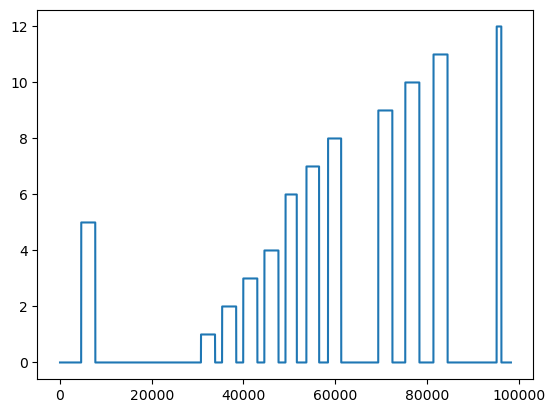

In [41]:
import os
import pandas as pd
import numpy as np


dataset_root = './data/mhealth_dataset'

dataset_dfs = list()

for fn in os.listdir(dataset_root):
    if not fn.endswith('.log'):
        continue
    with open(os.path.join(dataset_root, fn)) as f:
        data = f.readlines()
    data = [list(map(float, line.split('\t'))) for line in data]
    data_df = pd.DataFrame(data)

    columns_mapping = {c: f'feature_{c}' if c < len(data_df.columns) - 1 else 'label' for c in data_df.columns}
    data_df = data_df.rename(columns=columns_mapping)

    data_df['label'] = data_df.label.astype(int)
    data_df['subject'] = fn.split('_')[1].split('.')[0]
    dataset_dfs.append(data_df)

print(pd.concat(df.label for df in dataset_dfs).value_counts())
data_df.label.plot()

Как-то надо засубсемплить это все, ничего не сломав

In [80]:
def slice_df_by_label_changepoints(df):
    changepoint_indices = np.where(df.label[:-1].to_numpy() - df.label[1:].to_numpy())[0] + 1
    slices = list()

    left = 0

    for idx in changepoint_indices:
        slices.append(df.iloc[left: idx])
        left = idx

    slices.append(df.iloc[left:])

    return slices


def merge_slices_by_label(slices):
    grouped_slices = dict()
    for s in slices:
        slice_label = s.iloc[0].label
        if slice_label not in grouped_slices:
            grouped_slices[slice_label] = [s]
        else:
            grouped_slices[slice_label].append(s)

    return [pd.concat(group) for group in list(grouped_slices.values())]


dataset_slices = list()

for df in dataset_dfs:
    slices = slice_df_by_label_changepoints(df)
    slices = merge_slices_by_label(slices)

    dataset_slices.extend(slices)

dataset_slices = merge_slices_by_label(dataset_slices)
assert all([s.label.nunique() == 1 for s in dataset_slices])

# 0th class has to be downsampled, others are ok
downsampling_number = sorted([s.shape[0] for s in dataset_slices])[-2]
zero_class_slice_idx = [s.iloc[0].label for s in dataset_slices].index(0)

dataset_slices[zero_class_slice_idx] = dataset_slices[zero_class_slice_idx].groupby('subject').head(int(downsampling_number / dataset_slices[zero_class_slice_idx].subject.nunique()))

dataset_df = pd.concat(dataset_slices)
labels = dataset_df.label
dataset_df = dataset_df.drop(columns=['label', 'subject'])

assert labels.nunique() == 13
assert dataset_df.shape[0] == labels.shape[0]